In [1]:
from nba_api.stats.endpoints import CommonAllPlayers, ShotChartDetail
from supabase import create_client, Client
import pandas as pd
import numpy as np
import os
import time
import random

In [ ]:

supabase = create_client(SUPABASE_URL, SUPABASE_KEY)

In [3]:
# List of seasons from 2015-16 to 2024-25
seasons = [
    "2015-16", "2016-17", "2017-18", "2018-19", "2019-20",
    "2020-21", "2021-22", "2022-23", "2023-24", "2024-25"
]


all_players = pd.DataFrame()
seen_ids = set()

for season in seasons:
    print(f"Pulling players from season {season}")
    response = CommonAllPlayers(is_only_current_season=0, league_id="00", season=season)
    df = response.get_data_frames()[0]

    # Filter only players with ROSTERSTATUS == 1 (currently rostered)
    df = df[df["ROSTERSTATUS"] == 1]

    # Only add players not yet seen
    df = df[~df["PERSON_ID"].isin(seen_ids)]
    seen_ids.update(df["PERSON_ID"].tolist())

    all_players = pd.concat([all_players, df], ignore_index=True)
    time.sleep(1)

print(f"\n Collected {len(all_players)} unique players")

print(all_players)




Pulling players from season 2015-16
Pulling players from season 2016-17
Pulling players from season 2017-18
Pulling players from season 2018-19
Pulling players from season 2019-20
Pulling players from season 2020-21
Pulling players from season 2021-22
Pulling players from season 2022-23
Pulling players from season 2023-24
Pulling players from season 2024-25

 Collected 1333 unique players
      PERSON_ID DISPLAY_LAST_COMMA_FIRST DISPLAY_FIRST_LAST  ROSTERSTATUS  \
0        203112              Acy, Quincy         Quincy Acy             1   
1        203919            Adams, Jordan       Jordan Adams             1   
2        203500            Adams, Steven       Steven Adams             1   
3        201167           Afflalo, Arron      Arron Afflalo             1   
4        201582           Ajinca, Alexis      Alexis Ajinca             1   
...         ...                      ...                ...           ...   
1328    1641817            Watson, Anton       Anton Watson          

In [4]:
# Create a list of unique player IDs
player_ids = all_players["PERSON_ID"].tolist()

In [ ]:
all_shots = []
consecutive_failures = 0
failed_pairs = []
counter = 0

for season in seasons:
    for player_id in player_ids:
        counter += 1
        if counter % 100 == 0:
            print(f"Progress: {counter} player-season combos processed...")

        success = False

        try:
            chart = ShotChartDetail(
                player_id=player_id,
                team_id=0,
                season_nullable=season,
                season_type_all_star="Regular Season",
                context_measure_simple="FGA"
            )
            df = chart.get_data_frames()[0]

            if not df.empty:
                df["PLAYER_ID"] = player_id
                df["SEASON"] = season
                keep_cols = [
                    "GAME_ID", "GAME_EVENT_ID", "PLAYER_ID", "ACTION_TYPE", "SHOT_TYPE",
                    "SHOT_DISTANCE", "LOC_X", "LOC_Y", "SHOT_ATTEMPTED_FLAG", "SHOT_MADE_FLAG", "SEASON"
                ]
                df = df[keep_cols]
                all_shots.append(df)

            success = True
            consecutive_failures = 0  # reset on success

        except Exception as e:
            print(f"Failed for player {player_id} in {season}: {e}")

        if not success:
            failed_pairs.append((player_id, season))
            consecutive_failures += 1
            if consecutive_failures >= 2:
                print("Two consecutive player-season failures — exiting early.")
                break

        time.sleep(5)  # avoid rate limits

# Combine results
all_shots_df = pd.concat(all_shots, ignore_index=True)
print(f"Total shots collected: {len(all_shots_df)}")



Progress: 100 player-season combos processed...
Progress: 200 player-season combos processed...
Progress: 300 player-season combos processed...
Progress: 400 player-season combos processed...
Progress: 500 player-season combos processed...
Failed for player 201281 in 2015-16: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
Failed for player 1628371 in 2015-16: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
Two consecutive player-season failures — exiting early.
Failed for player 203112 in 2016-17: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
Two consecutive player-season failures — exiting early.
Failed for player 203112 in 2017-18: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
Two consecutive player-season failures — exiting early.
Failed for player 203112 in 2018-19: HTTPSConnectionPool(host='stats.nba.com', port=443): Read 

In [30]:
all_shots_df.to_csv("all_player_shotcharts.csv", index=False)

In [2]:
all_shots_df = pd.read_csv("all_player_shotcharts.csv")

zero_shot_pairs_df = pd.read_csv("zero_shots.csv")


In [32]:

print(all_shots_df)
print(zero_shot_pairs_df)

          GAME_ID  GAME_EVENT_ID  PLAYER_ID         ACTION_TYPE  \
0        21500092             64     203112           Jump Shot   
1        21500103            495     203112           Jump Shot   
2        21500137            396     203112           Jump Shot   
3        21500137            408     203112           Dunk Shot   
4        21500150            280     203112           Jump Shot   
...           ...            ...        ...                 ...   
2096380  22401193            495    1629111          Layup Shot   
2096381  22401193            516    1629111  Putback Layup Shot   
2096382  22401193            536    1629111           Jump Shot   
2096383  22401193            550    1629111           Jump Shot   
2096384  22401193            562    1629111  Floating Jump shot   

              SHOT_TYPE  SHOT_DISTANCE  LOC_X  LOC_Y  SHOT_ATTEMPTED_FLAG  \
0        2PT Field Goal              6    -22     56                    1   
1        3PT Field Goal             24   

In [33]:
unique_pairs = all_shots_df[["PLAYER_ID", "SEASON"]].drop_duplicates()
print(unique_pairs)



         PLAYER_ID   SEASON
0           203112  2015-16
213         203919  2015-16
219         203500  2015-16
645         201167  2015-16
1442        201582  2015-16
...            ...      ...
2095459    1626170  2019-20
2095486    1629111  2021-22
2095690    1629111  2022-23
2096027    1629111  2023-24
2096233    1629111  2024-25

[5216 rows x 2 columns]


In [34]:
zero_shot_set = set(zip(zero_shot_pairs_df["PLAYER_ID"], zero_shot_pairs_df["SEASON"]))
print(zero_shot_set)

{(203546, '2021-22'), (1629061, '2015-16'), (1626184, '2021-22'), (1630557, '2020-21'), (1628403, '2015-16'), (1630204, '2016-17'), (1630600, '2016-17'), (1628681, '2022-23'), (201965, '2020-21'), (1629012, '2015-16'), (1642050, '2020-21'), (1631093, '2017-18'), (2588, '2019-20'), (200770, '2019-20'), (1627779, '2023-24'), (203710, '2021-22'), (1630253, '2023-24'), (1627868, '2018-19'), (1641717, '2021-22'), (1630587, '2020-21'), (204037, '2016-17'), (1630234, '2016-17'), (1631306, '2017-18'), (1627858, '2023-24'), (1641763, '2019-20'), (203923, '2021-22'), (203527, '2021-22'), (101187, '2024-25'), (2210, '2020-21'), (1631123, '2017-18'), (1630581, '2016-17'), (1630185, '2016-17'), (1628422, '2024-25'), (1641842, '2019-20'), (2546, '2022-23'), (1630166, '2019-20'), (1628405, '2020-21'), (2440, '2024-25'), (1641747, '2021-22'), (1626161, '2024-25'), (1628373, '2024-25'), (200751, '2019-20'), (1641705, '2015-16'), (203580, '2022-23'), (1630284, '2021-22'), (1630611, '2016-17'), (1630215,

In [35]:
done_player_seasons = set(zip(all_shots_df["PLAYER_ID"], all_shots_df["SEASON"])).union(zero_shot_set)

print(len(done_player_seasons))

13320


In [36]:
# Full set of player × season pairs
all_pairs = [(pid, s) for s in seasons for pid in player_ids]
next_pairs = [pair for pair in all_pairs if pair not in done_player_seasons][::-1]

print(next_pairs)

[]


In [37]:
player_id2 = sorted(set(pid for pid, _ in next_pairs))
random.shuffle(player_id2)
print(player_id2)

[]


In [25]:
new_shots = []
failed_pairs = []
zero_shot_pairs = []
consecutive_failures = 0
counter = 0

# Loop through new pairs
for player_id in player_id2:
    for season in seasons:
        if (player_id, season) in done_player_seasons:
            continue  # skip already done

        counter += 1
        if counter % 100 == 0:
            print(f"Progress: {counter} player-season combos processed...")

        success = False

        try:
            chart = ShotChartDetail(
                player_id=player_id,
                team_id=0,
                season_nullable=season,
                season_type_all_star="Regular Season",
                context_measure_simple="FGA"
            )
            df = chart.get_data_frames()[0]

            if df.empty:
                zero_shot_pairs.append((player_id, season))
            else:
                df["PLAYER_ID"] = player_id
                df["SEASON"] = season
                keep_cols = [
                    "GAME_ID", "GAME_EVENT_ID", "PLAYER_ID", "ACTION_TYPE", "SHOT_TYPE",
                    "SHOT_DISTANCE", "LOC_X", "LOC_Y", "SHOT_ATTEMPTED_FLAG", "SHOT_MADE_FLAG", "SEASON"
                ]
                df = df[keep_cols]
                new_shots.append(df)

            success = True
            consecutive_failures = 0  

        except Exception as e:
            print(f"Failed for player {player_id} in {season}: {e}")
            failed_pairs.append((player_id, season))
            consecutive_failures += 1

        if not success:
            print(f"Skipped player {player_id} in {season}")
            if consecutive_failures >= 20:
                print("Too many consecutive failures — exiting early.")
                break

        time.sleep(15)

    if consecutive_failures >= 20:
        break  # exit outer loop too

print(f"new_shots.df contains {len(new_shots)} rows.")
print(f"{len(zero_shot_pairs)} player-season pairs had 0 shots.")

new_shots.df contains 0 rows.
12 player-season pairs had 0 shots.


In [26]:
print(new_shots)

[]


In [27]:
all_shots_df = pd.concat([all_shots_df] + new_shots, ignore_index=True)
print(f"Final shotchart_df contains {len(all_shots_df)} rows.")




Final shotchart_df contains 2096385 rows.


In [28]:
zero_shot_pairs = pd.DataFrame(zero_shot_pairs, columns=["PLAYER_ID", "SEASON"])

zero_shot_pairs_df = pd.concat([zero_shot_pairs_df, zero_shot_pairs], ignore_index=True)

print(zero_shot_pairs_df)

      PLAYER_ID   SEASON
0       1642403  2015-16
1       1642403  2016-17
2       1642403  2017-18
3       1642403  2018-19
4       1642403  2019-20
...         ...      ...
8497    1641738  2020-21
8498     201586  2024-25
8499    1641809  2022-23
8500    1627832  2015-16
8501    1641711  2015-16

[8502 rows x 2 columns]


In [29]:

zero_shot_pairs_df.to_csv("zero_shots.csv", index=False)

In [22]:
lebron_id = 1642377
season = "2019-20"

chart = ShotChartDetail(
    player_id=lebron_id,
    team_id=0,
    season_nullable=season,
    season_type_all_star="Regular Season",
    context_measure_simple="FGA"
)

lebron_df = chart.get_data_frames()[0]
print(f"✅ Pulled {len(lebron_df)} shots for LeBron in {season}")
lebron_df.head()

✅ Pulled 0 shots for LeBron in 2019-20


,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM


In [4]:
all_shots_df.columns

Index(['GAME_ID', 'GAME_EVENT_ID', 'PLAYER_ID', 'ACTION_TYPE', 'SHOT_TYPE',
       'SHOT_DISTANCE', 'LOC_X', 'LOC_Y', 'SHOT_ATTEMPTED_FLAG',
       'SHOT_MADE_FLAG', 'SEASON'],
      dtype='object')

In [5]:
print(all_shots_df[["LOC_X", "LOC_Y"]].describe())

              LOC_X         LOC_Y
count  2.096385e+06  2.096385e+06
mean  -1.641785e+00  9.342800e+01
std    1.116973e+02  9.443038e+01
min   -2.500000e+02 -5.200000e+01
25%   -4.900000e+01  1.200000e+01
50%    0.000000e+00  5.300000e+01
75%    4.600000e+01  1.780000e+02
max    2.500000e+02  8.780000e+02


In [3]:
# Mirror Y if shot taken beyond half court (Y > 470 inches)
all_shots_df["LOC_Y_HALF"] = all_shots_df["LOC_Y"].apply(lambda y: 940 - y if y > 470 else y)

# Mirror X only if the shot was taken beyond half court 
all_shots_df["LOC_X_HALF"] = all_shots_df.apply(
    lambda row: -row["LOC_X"] if row["LOC_Y"] > 470 else row["LOC_X"],
    axis=1
)

In [4]:
hex_bin_size = 5

all_shots_df["HEX_X"] = (all_shots_df["LOC_X_HALF"] // hex_bin_size).astype(int)
all_shots_df["HEX_Y"] = (all_shots_df["LOC_Y_HALF"] // hex_bin_size).astype(int)

print(all_shots_df)

          GAME_ID  GAME_EVENT_ID  PLAYER_ID         ACTION_TYPE  \
0        21500092             64     203112           Jump Shot   
1        21500103            495     203112           Jump Shot   
2        21500137            396     203112           Jump Shot   
3        21500137            408     203112           Dunk Shot   
4        21500150            280     203112           Jump Shot   
...           ...            ...        ...                 ...   
2096380  22401193            495    1629111          Layup Shot   
2096381  22401193            516    1629111  Putback Layup Shot   
2096382  22401193            536    1629111           Jump Shot   
2096383  22401193            550    1629111           Jump Shot   
2096384  22401193            562    1629111  Floating Jump shot   

              SHOT_TYPE  SHOT_DISTANCE  LOC_X  LOC_Y  SHOT_ATTEMPTED_FLAG  \
0        2PT Field Goal              6    -22     56                    1   
1        3PT Field Goal             24   

In [5]:
league_hex = (
    all_shots_df
    .groupby(["SEASON", "HEX_X", "HEX_Y"])
    .agg(
        total_shots=("SHOT_ATTEMPTED_FLAG", "sum"),
        made_shots=("SHOT_MADE_FLAG", "sum")
    )
    .reset_index()
)

league_hex["LEAGUE_FG_PCT"] = league_hex["made_shots"] / league_hex["total_shots"]

print(league_hex)

        SEASON  HEX_X  HEX_Y  total_shots  made_shots  LEAGUE_FG_PCT
0      2015-16    -50     -7            1           0       0.000000
1      2015-16    -50     -6            7           4       0.571429
2      2015-16    -50     -5           11           5       0.454545
3      2015-16    -50     -4           24          13       0.541667
4      2015-16    -50     -3           24          11       0.458333
...        ...    ...    ...          ...         ...            ...
65653  2024-25     49     24            1           0       0.000000
65654  2024-25     49     58            1           1       1.000000
65655  2024-25     50     -1            1           1       1.000000
65656  2024-25     50      8            2           0       0.000000
65657  2024-25     50      9            1           0       0.000000

[65658 rows x 6 columns]


In [6]:
player_hex = (
    all_shots_df
    .groupby(["PLAYER_ID", "SEASON", "HEX_X", "HEX_Y"])
    .agg(
        player_total_shots=("SHOT_ATTEMPTED_FLAG", "sum"),
        player_made_shots=("SHOT_MADE_FLAG", "sum")
    )
    .reset_index()
)

player_hex["PLAYER_FG_PCT"] = player_hex["player_made_shots"] / player_hex["player_total_shots"]

player_hex["FREQ_PCT"] = player_hex["player_total_shots"] / player_hex.groupby(["PLAYER_ID", "SEASON"])["player_total_shots"].transform("sum")

player_hex = player_hex[player_hex["player_total_shots"] >= 2 ]


print(player_hex)

         PLAYER_ID   SEASON  HEX_X  HEX_Y  player_total_shots  \
22             708  2015-16    -24     30                   2   
56             708  2015-16     -2      0                   2   
63             708  2015-16      0     11                   3   
111            977  2015-16    -50     -4                   2   
117            977  2015-16    -48     -2                   2   
...            ...      ...    ...    ...                 ...   
1503451    1642419  2024-25     46      1                   3   
1503453    1642419  2024-25     46      3                   2   
1503455    1642419  2024-25     46     11                   2   
1503464    1642419  2024-25     47      7                   2   
1503493    1642461  2024-25    -47      0                   2   

         player_made_shots  PLAYER_FG_PCT  FREQ_PCT  
22                       0       0.000000  0.017391  
56                       1       0.500000  0.017391  
63                       1       0.333333  0.026087  
111

In [7]:
merged = player_hex.merge(
    league_hex,
    on=["SEASON", "HEX_X", "HEX_Y"],
    how="left"
)

merged["FG_PCT_DIFF"] = merged["PLAYER_FG_PCT"] - merged["LEAGUE_FG_PCT"]

print(merged)


        PLAYER_ID   SEASON  HEX_X  HEX_Y  player_total_shots  \
0             708  2015-16    -24     30                   2   
1             708  2015-16     -2      0                   2   
2             708  2015-16      0     11                   3   
3             977  2015-16    -50     -4                   2   
4             977  2015-16    -48     -2                   2   
...           ...      ...    ...    ...                 ...   
286942    1642419  2024-25     46      1                   3   
286943    1642419  2024-25     46      3                   2   
286944    1642419  2024-25     46     11                   2   
286945    1642419  2024-25     47      7                   2   
286946    1642461  2024-25    -47      0                   2   

        player_made_shots  PLAYER_FG_PCT  FREQ_PCT  total_shots  made_shots  \
0                       0       0.000000  0.017391           41          13   
1                       1       0.500000  0.017391         1435         9

In [8]:
merged_24 = merged[merged["PLAYER_ID"]== 977] 
print(merged_24)

     PLAYER_ID   SEASON  HEX_X  HEX_Y  player_total_shots  player_made_shots  \
3          977  2015-16    -50     -4                   2                  1   
4          977  2015-16    -48     -2                   2                  1   
5          977  2015-16    -48     10                   2                  0   
6          977  2015-16    -45     16                   2                  0   
7          977  2015-16    -44     24                   2                  1   
..         ...      ...    ...    ...                 ...                ...   
157        977  2015-16     43     29                   2                  0   
158        977  2015-16     45     22                   2                  1   
159        977  2015-16     46     -6                   2                  0   
160        977  2015-16     47     -2                   2                  1   
161        977  2015-16     47      2                   2                  2   

     PLAYER_FG_PCT  FREQ_PCT  total_sho

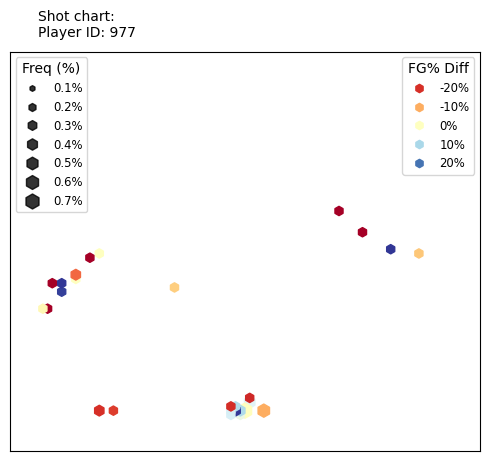

In [85]:
import matplotlib.pyplot as plt
import numpy as np

# Clip FG% differential to ±10% and convert to % scale
clip_cmap = (-0.25, 0.25)
z = np.array([
    max(min(diff, clip_cmap[1]), clip_cmap[0])
    for diff in merged_24["FG_PCT_DIFF"]
]) * 100

# Filter low-frequency hexes
freq = merged_24["FREQ_PCT"].values
filter_threshold = 0.002
freq[freq <= filter_threshold] = 0

# Rescale sizes
sizes = freq / freq.max() * 120
max_freq = freq.max()
max_size = sizes.max()

# Convert HEX_X and HEX_Y back to court coordinates
hex_bin_size = 5
x = merged_24["HEX_X"] * hex_bin_size
y = merged_24["HEX_Y"] * hex_bin_size

# Plot
plt.figure(figsize=(5, 4.7))
plt.xlim(250, -250)
plt.ylim(-47.5, 422.5)

scatter = plt.scatter(x, y, c=z, s=sizes, cmap='RdYlBu', marker='h')

plt.text(220, 440, "Shot chart:\nPlayer ID: {}".format(merged_24["PLAYER_ID"].iloc[0]))


ax = plt.gca()
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

# Legends
legend1 = plt.legend(
    *scatter.legend_elements(num=6, fmt="{x:.0f}%"),
    loc="upper right", title="FG% Diff", fontsize="small"
)
legend2 = plt.legend(
    *scatter.legend_elements(
        'sizes', num=6, alpha=0.8, fmt="{x:.1f}%",
        func=lambda s: s / max_size * max_freq * 100
    ),
    loc="upper left", title="Freq (%)", fontsize="small"
)
ax.add_artist(legend1)
plt.tight_layout()
plt.show()


In [12]:
import numpy as np
import plotly.graph_objects as go

def add_nba_halfcourt(fig, lw=2, color='black'):
    # Helper to add arc
    def add_arc(x_center, y_center, width, height, theta1, theta2, dashed=False):
        theta = np.radians(np.linspace(theta1, theta2, 100))
        x = x_center + (width / 2) * np.cos(theta)
        y = y_center + (height / 2) * np.sin(theta)
        fig.add_trace(go.Scatter(
            x=x, y=y, mode='lines',
            line=dict(color=color, width=lw, dash='dash' if dashed else 'solid'),
            hoverinfo='skip',
            showlegend=False
        ))

    # Hoop
    fig.add_shape(type="circle", x0=-7.5, y0=-7.5, x1=7.5, y1=7.5,
                  line=dict(color=color, width=lw))

    # Backboard
    fig.add_shape(type="rect", x0=-30, y0=-8.5, x1=30, y1=-7.5,
                  line=dict(color=color, width=lw))

    # Paint - outer box
    fig.add_shape(type="rect", x0=-80, y0=-47.5, x1=80, y1=142.5,
                  line=dict(color=color, width=lw))

    # Paint - inner box
    fig.add_shape(type="rect", x0=-60, y0=-47.5, x1=60, y1=142.5,
                  line=dict(color=color, width=lw))

    # Free throw arcs
    add_arc(0, 142.5, 120, 120, 0, 180)      # Top arc
    add_arc(0, 142.5, 120, 120, 180, 0, dashed=True)  # Bottom arc (dashed)

    # Restricted area
    add_arc(0, 0, 80, 80, 0, 180)

    # Corner threes
    fig.add_shape(type="line", x0=-220, y0=-47.5, x1=-220, y1=92.5,
                  line=dict(color=color, width=lw))
    fig.add_shape(type="line", x0=220, y0=-47.5, x1=220, y1=92.5,
                  line=dict(color=color, width=lw))

    # 3pt arc
    add_arc(0, 0, 475, 475, 22, 158)

    # Halfcourt arcs
    add_arc(0, 422.5, 120, 120, 180, 0)
    add_arc(0, 422.5, 40, 40, 180, 0)

    # Outer lines (optional full half-court box)
    fig.add_shape(type="rect", x0=-250, y0=-47.5, x1=250, y1=422.5,
                  line=dict(color=color, width=lw))

    return fig


In [13]:
fig = px.scatter(
    merged_24,
    x="x",
    y="y",
    color="CLIPPED_DIFF",
    size="SCALED_SIZE",
    color_continuous_scale="RdYlBu",
    size_max=30,
    hover_data={
        "CLIPPED_DIFF": True,
        "FREQ_PCT": True,
        "x": False,
        "y": False
    },
    title=f"Shot Chart – Player ID: {merged_24['PLAYER_ID'].iloc[0]}"
)

fig.update_traces(marker=dict(symbol="hexagon", line=dict(width=0)))

fig.update_layout(
    xaxis=dict(range=[250, -250], visible=False),
    yaxis=dict(range=[-47.5, 422.5], visible=False),
    plot_bgcolor="white",
    showlegend=False,
    width=500,
    height=470,
    margin=dict(t=60, b=0, l=0, r=0)
)

# 🏀 Add court overlay
fig = add_nba_halfcourt(fig)
fig.show()



In [17]:
# Create SQL to define your table schema
def generate_supabase_sql(df, table_name):
    sql_cols = []
    for col in df.columns:
        dtype = df[col].dtype
        if pd.api.types.is_integer_dtype(dtype):
            sql_cols.append(f'"{col}" bigint')
        elif pd.api.types.is_float_dtype(dtype):
            sql_cols.append(f'"{col}" double precision')
        else:
            sql_cols.append(f'"{col}" text')  # text for object, str, etc.

    sql_statement = f"CREATE TABLE {table_name} (\n  " + ",\n  ".join(sql_cols) + "\n);"
    return sql_statement

In [18]:
player_bins_sql = generate_supabase_sql(merged, "player_shot_bins")
print(player_bins_sql)

CREATE TABLE player_shot_bins (
  "PLAYER_ID" bigint,
  "SEASON" text,
  "HEX_X" bigint,
  "HEX_Y" bigint,
  "player_total_shots" bigint,
  "player_made_shots" bigint,
  "PLAYER_FG_PCT" double precision,
  "FREQ_PCT" double precision,
  "total_shots" bigint,
  "made_shots" bigint,
  "LEAGUE_FG_PCT" double precision,
  "FG_PCT_DIFF" double precision
);


In [86]:
player_records = merged.to_dict(orient="records")
chunk_size = 1000

for i in range(0, len(player_records), chunk_size):
    chunk = player_records[i:i + chunk_size]
    try:
        supabase.table("player_shot_bins").insert(chunk).execute()
        print(f"Inserted player chunk {i // chunk_size + 1}")
    except Exception as e:
        print(f"Error inserting player chunk {i // chunk_size + 1}: {e}")

Inserted player chunk 1
Inserted player chunk 2
Inserted player chunk 3
Inserted player chunk 4
Inserted player chunk 5
Inserted player chunk 6
Inserted player chunk 7
Inserted player chunk 8
Inserted player chunk 9
Inserted player chunk 10
Inserted player chunk 11
Inserted player chunk 12
Inserted player chunk 13
Inserted player chunk 14
Inserted player chunk 15
Inserted player chunk 16
Inserted player chunk 17
Inserted player chunk 18
Inserted player chunk 19
Inserted player chunk 20
Inserted player chunk 21
Inserted player chunk 22
Inserted player chunk 23
Inserted player chunk 24
Inserted player chunk 25
Inserted player chunk 26
Inserted player chunk 27
Inserted player chunk 28
Inserted player chunk 29
Inserted player chunk 30
Inserted player chunk 31
Inserted player chunk 32
Inserted player chunk 33
Inserted player chunk 34
Inserted player chunk 35
Inserted player chunk 36
Inserted player chunk 37
Inserted player chunk 38
Inserted player chunk 39
Inserted player chunk 40
Inserted 